# Pipeline Project

You will be using the provided data to create a machine learning model pipeline.

You must handle the data appropriately in your pipeline to predict whether an
item is recommended by a customer based on their review.
Note the data includes numerical, categorical, and text data.

You should ensure you properly train and evaluate your model.

## The Data

The dataset has been anonymized and cleaned of missing values.

There are 8 features for to use to predict whether a customer recommends or does
not recommend a product.
The `Recommended IND` column gives whether a customer recommends the product
where `1` is recommended and a `0` is not recommended.
This is your model's target/

The features can be summarized as the following:

- **Clothing ID**: Integer Categorical variable that refers to the specific piece being reviewed.
- **Age**: Positive Integer variable of the reviewers age.
- **Title**: String variable for the title of the review.
- **Review Text**: String variable for the review body.
- **Positive Feedback Count**: Positive Integer documenting the number of other customers who found this review positive.
- **Division Name**: Categorical name of the product high level division.
- **Department Name**: Categorical name of the product department name.
- **Class Name**: Categorical name of the product class name.

The target:
- **Recommended IND**: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

## Load Data

In [34]:
# Imports
import numpy as np
import spacy
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from scipy.stats import randint

In [3]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [4]:
# Custom tokenizer
def spacy_tokenizer(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]

In [5]:
import pandas as pd

# Load data
df = pd.read_csv(
    'starter/data/reviews.csv',
)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18442 entries, 0 to 18441
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              18442 non-null  int64 
 1   Age                      18442 non-null  int64 
 2   Title                    18442 non-null  object
 3   Review Text              18442 non-null  object
 4   Positive Feedback Count  18442 non-null  int64 
 5   Division Name            18442 non-null  object
 6   Department Name          18442 non-null  object
 7   Class Name               18442 non-null  object
 8   Recommended IND          18442 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.3+ MB


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name,Recommended IND
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses,0
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants,1
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses,1
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses,0
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits,1


## Preparing features (`X`) & target (`y`)

In [6]:
data = df

# separate features from labels
X = data.drop('Recommended IND', axis=1)
y = data['Recommended IND'].copy()

print('Labels:', y.unique())
print('Features:')
display(X.head())

Labels: [0 1]
Features:


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits


In [7]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    shuffle=True,
    random_state=27,
)

# Your Work

## Data Exploration

In [8]:
df.shape  # Rows and columns

(18442, 9)

In [9]:
df.describe(include='all')

,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name,Recommended IND
count,18442.000000,18442.000000,18442,18442,18442.000000,18442,18442,18442,18442.000000
unique,NaN,NaN,13142,18439,NaN,2,6,14,NaN
top,NaN,NaN,Love it!,I bought this shirt at the store and after goi...,NaN,General,Tops,Dresses,NaN
freq,NaN,NaN,129,2,NaN,11664,8713,5371,NaN
mean,954.896757,43.383635,NaN,NaN,2.697484,NaN,NaN,NaN,0.816235
std,141.571783,12.246264,NaN,NaN,5.942220,NaN,NaN,NaN,0.387303
min,2.000000,18.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000
25%,863.000000,34.000000,NaN,NaN,0.000000,NaN,NaN,NaN,1.000000
50%,952.000000,41.000000,NaN,NaN,1.000000,NaN,NaN,NaN,1.000000
75%,1078.000000,52.000000,NaN,NaN,3.000000,NaN,NaN,NaN,1.000000


In [10]:
# Check missing values
df.isnull().sum()

Clothing ID                0
Age                        0
Title                      0
Review Text                0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
Recommended IND            0
dtype: int64

<Axes: xlabel='Recommended IND'>

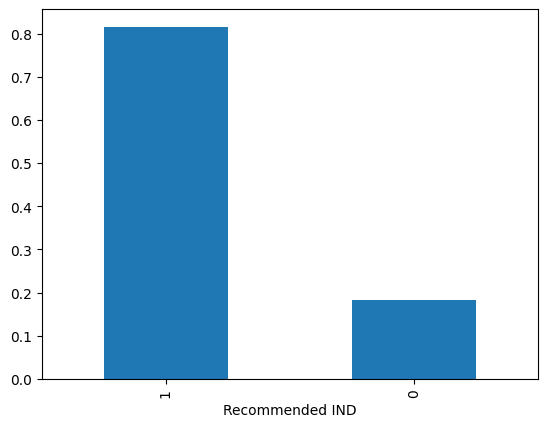

In [11]:
df['Recommended IND'].value_counts(normalize=True).plot(kind='bar')

<Axes: title={'center': 'Age Distribution'}, ylabel='Frequency'>

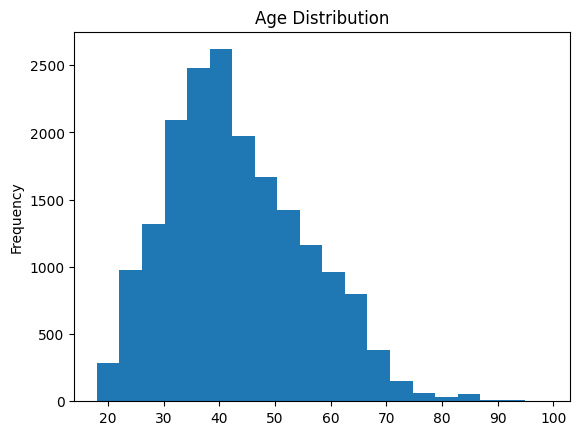

In [12]:
# Age distribution
df['Age'].plot(kind='hist', bins=20, title='Age Distribution')

<Axes: >

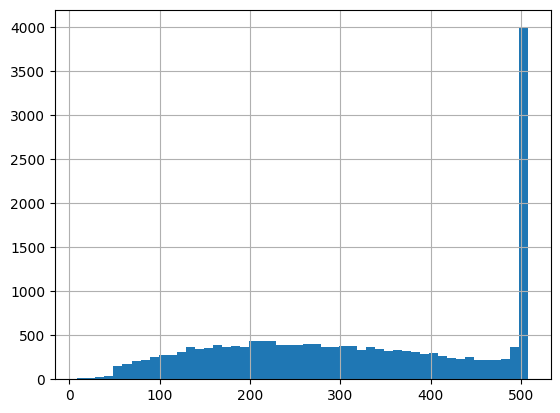

In [13]:
# Review text length Analysis
df['Review Length'] = df['Review Text'].astype(str).apply(len)
df['Review Length'].hist(bins=50)

In [14]:
# Feature types
num_features = ['Age', 'Positive Feedback Count']
cat_features = ['Division Name', 'Department Name', 'Class Name']

In [15]:
# Transformers
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')
text_vectorizer_review = TfidfVectorizer(tokenizer=spacy_tokenizer, max_features=5000)
text_vectorizer_title = TfidfVectorizer(tokenizer=spacy_tokenizer, max_features=1000)

## Building Pipeline

In [16]:
# Column transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features),
    ('review', text_vectorizer_review, 'Review Text'),
    ('title', text_vectorizer_title, 'Title'),
], remainder='drop', sparse_threshold=0.3)

In [17]:
%%time
# Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=27))
])

CPU times: total: 0 ns
Wall time: 0 ns


## Training Pipeline

In [18]:
%%time
# Train model
pipeline.fit(X_train, y_train)

C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: total: 6min 45s
Wall time: 6min 48s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age',
                                                   'Positive Feedback Count']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Division Name',
                                                   'Department Name',
                                                   'Class Name']),
                                                 ('review',
                                                  TfidfVectorizer(max_features=5000,
                                                                  tokenizer=<function spacy_tokenizer at 0x000001E801EE8790>),
                                                  'Review Text'),
                                                 ('title',
                                                  TfidfVectorizer(max_features=1000,
                                                                  tokenizer=<function spacy_tokenizer at 0x000001E801EE8790>),
                                                  'Title')])),
                ('classifier', RandomForestClassifier(random_state=27))])

In [20]:
%%time
# Evaluate
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.27      0.40       327
           1       0.86      0.99      0.92      1518

    accuracy                           0.86      1845
   macro avg       0.83      0.63      0.66      1845
weighted avg       0.85      0.86      0.83      1845

CPU times: total: 39.7 s
Wall time: 40.2 s


In [25]:
# Calculate metrics
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'AUC': roc_auc_score(y_test, y_pred)
}

In [50]:
# Display metrics as table
metrics_df = pd.DataFrame([metrics])
metrics_df

,Accuracy,Precision,Recall,F1 Score,AUC
0,0.857995,0.861751,0.985507,0.919484,0.625781


## Fine-Tuning Pipeline

In [32]:
# RandomizedSearchCV for hyperparameter tuning
param_distributions = {
    'classifier__n_estimators': randint(100, 500),
    'classifier__max_depth': [None, 10, 20, 30, 50],
    'classifier__min_samples_split': randint(2, 10),
    'classifier__min_samples_leaf': randint(1, 5),
    'classifier__bootstrap': [True, False]
}

In [37]:

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=27
)

In [38]:
%%time
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END classifier__bootstrap=False, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=9, classifier__n_estimators=412; total time= 8.0min


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END classifier__bootstrap=False, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=9, classifier__n_estimators=412; total time= 7.9min


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END classifier__bootstrap=False, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=9, classifier__n_estimators=412; total time= 8.0min


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__min_samples_leaf=2, classifier__min_samples_split=7, classifier__n_estimators=469; total time= 7.6min


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__min_samples_leaf=2, classifier__min_samples_split=7, classifier__n_estimators=469; total time= 7.5min


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__min_samples_leaf=2, classifier__min_samples_split=7, classifier__n_estimators=469; total time= 4.3min


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__min_samples_leaf=2, classifier__min_samples_split=8, classifier__n_estimators=494; total time= 3.3min


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__min_samples_leaf=2, classifier__min_samples_split=8, classifier__n_estimators=494; total time= 3.3min


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__min_samples_leaf=2, classifier__min_samples_split=8, classifier__n_estimators=494; total time= 3.3min


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=259; total time= 3.5min


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=259; total time= 3.4min


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=259; total time= 3.3min


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__min_samples_leaf=3, classifier__min_samples_split=2, classifier__n_estimators=441; total time= 3.3min


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__min_samples_leaf=3, classifier__min_samples_split=2, classifier__n_estimators=441; total time= 3.3min


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__min_samples_leaf=3, classifier__min_samples_split=2, classifier__n_estimators=441; total time= 3.4min


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=318; total time= 3.7min


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=318; total time= 3.6min


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END classifier__bootstrap=False, classifier__max_depth=50, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=318; total time= 3.4min


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__min_samples_leaf=3, classifier__min_samples_split=9, classifier__n_estimators=193; total time= 3.3min


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__min_samples_leaf=3, classifier__min_samples_split=9, classifier__n_estimators=193; total time= 3.2min


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END classifier__bootstrap=True, classifier__max_depth=50, classifier__min_samples_leaf=3, classifier__min_samples_split=9, classifier__n_estimators=193; total time= 3.4min


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__min_samples_leaf=1, classifier__min_samples_split=7, classifier__n_estimators=133; total time= 3.3min


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__min_samples_leaf=1, classifier__min_samples_split=7, classifier__n_estimators=133; total time= 7.3min


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__min_samples_leaf=1, classifier__min_samples_split=7, classifier__n_estimators=133; total time= 6.9min


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifier__n_estimators=233; total time= 3.8min


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifier__n_estimators=233; total time= 3.5min


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifier__n_estimators=233; total time= 3.6min


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=379; total time= 3.7min


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=379; total time= 3.4min


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=379; total time= 3.4min


C:\Users\HP\anaconda3\envs\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: total: 2h 15min 4s
Wall time: 2h 17min 20s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['Age',
                                                                                'Positive '
                                                                                'Feedback '
                                                                                'Count']),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['Division '
                                                                                'Name',
                                                                                'Department '
                                                                                'Name',
                                                                                'Class '
                                                                                'Name']),
                                                                              ('review',
                                                                               TfidfVectorizer(max_features=5000,
                                                                                               tokenizer=<function spacy_tokenizer at 0x000001E801...
                                        'classifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001E80EFAB880>,
                                        'classifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001E80EFABF10>,
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001E80EFC4880>},
                   random_state=27, verbose=2)

In [39]:
print("Best Parameters Found:")
print(random_search.best_params_)

Best Parameters Found:
{'classifier__bootstrap': False, 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 9, 'classifier__n_estimators': 412}


In [40]:
%%time
# Evaluate best model
y_pred_best = random_search.predict(X_test)

CPU times: total: 17.9 s
Wall time: 18 s


In [41]:
%%time
# Classification Report
print("Evaluation Report (Tuned Model):")
print(classification_report(y_test, y_pred_best))

Evaluation Report (Tuned Model):
              precision    recall  f1-score   support

           0       0.86      0.31      0.46       327
           1       0.87      0.99      0.93      1518

    accuracy                           0.87      1845
   macro avg       0.86      0.65      0.69      1845
weighted avg       0.87      0.87      0.84      1845

CPU times: total: 15.6 ms
Wall time: 43 ms


In [42]:
# Calculate metrics
metrics_tuned = {
    'Accuracy': accuracy_score(y_test, y_pred_best),
    'Precision': precision_score(y_test, y_pred_best),
    'Recall': recall_score(y_test, y_pred_best),
    'F1 Score': f1_score(y_test, y_pred_best),
    'AUC': roc_auc_score(y_test, y_pred_best)
}

In [47]:
# Display metrics as table
metrics_df_tuned = pd.DataFrame([metrics_tuned])
metrics_df_tuned

,Accuracy,Precision,Recall,F1 Score,AUC
0,0.869377,0.870145,0.988801,0.925686,0.651893


In [52]:
stacked_df = pd.concat([metrics_df, metrics_df_tuned], ignore_index=True)
stacked_df.index = ['before_tuning', 'after_tuning']
stacked_df

,Accuracy,Precision,Recall,F1 Score,AUC
before_tuning,0.857995,0.861751,0.985507,0.919484,0.625781
after_tuning,0.869377,0.870145,0.988801,0.925686,0.651893


There is slight improvement in Accuracy, Precision, Recall, F1 and AUC with AUC having the highest improvement